Importing libraries

In [349]:
import urllib.request
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
import numpy as np
import folium
import plotly.express as px

Downloading required files 

In [72]:
# Source: https://towardsdatascience.com/automatically-update-data-sources-in-python-e424dbea68d0
def download_files(url, output):
    print("Start Program ... ")
    try:
        print("Start Downloading file ... ")
        urllib.request.urlretrieve(url, output)
        print(f"File {output} -- saved!")
    except Exception as e:
        print("Downloading file error: " + str(e))
        print ("Dataframe was created with the most recent download")
    return pd.read_csv(output, compression='gzip')

In [73]:
# Downloading files from https://data.brasil.io/dataset/covid19/_meta/list.html
# This function tries to get the most recent version of the datasets
# if the download fails, it will generate the dataframe with the github dataset

df_cases = download_files('https://data.brasil.io/dataset/covid19/caso.csv.gz', 'cases.csv.gz')
df_full = download_files('https://data.brasil.io/dataset/covid19/caso_full.csv.gz', 'cases_full.csv.gz')
df_death = download_files('https://data.brasil.io/dataset/covid19/obito_cartorio.csv.gz', 'death_data.csv.gz')

Start Program ... 
Start Downloading file ... 
File cases.csv.gz -- saved!
Start Program ... 
Start Downloading file ... 
File cases_full.csv.gz -- saved!
Start Program ... 
Start Downloading file ... 
File death_data.csv.gz -- saved!


Loading files

In [74]:
# Reading in files from civil-registry

cr_deaths = pd.read_csv('civil_registry_deaths.csv')
cr_states = pd.read_csv('civil_registry_covid_states.csv')
cr_states_det = pd.read_csv('civil_registry_covid_states_detailed.csv')
cr_city = pd.read_csv('civil_registry_covid_cities.csv')
cr_city_det = pd.read_csv('civil_registry_covid_cities_detailed.csv')

In [219]:
# Reading long/lat data

state_coor = pd.read_csv('data_long_lat/estados.csv')
city_coor = pd.read_csv('data_long_lat/municipios.csv')

In [290]:
# Renaming columns and removing symbols

state_coor.rename(columns={'uf': 'state'}, inplace = True)
state_coor['nome'] = state_coor['nome'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

Data Exploration

In [75]:
cr_states_det.dtypes

date                           object
state                          object
state_ibge_code                 int64
place                          object
gender                         object
age_group                      object
deaths_sars                   float64
deaths_pneumonia              float64
deaths_respiratory_failure    float64
deaths_septicemia             float64
deaths_indeterminate          float64
deaths_others                 float64
deaths_covid19                float64
created_at                     object
dtype: object

In [76]:
cr_states_det.isnull().mean()

date                          0.000000
state                         0.000000
state_ibge_code               0.000000
place                         0.000000
gender                        0.000000
age_group                     0.033541
deaths_sars                   0.982897
deaths_pneumonia              0.684064
deaths_respiratory_failure    0.772681
deaths_septicemia             0.722977
deaths_indeterminate          0.969530
deaths_others                 0.172677
deaths_covid19                0.973206
created_at                    0.000000
dtype: float64

In [77]:
cr_states_det['gender'].value_counts()

M    198253
F    164558
Name: gender, dtype: int64

In [78]:
cr_states_det['age_group'].value_counts().sort_values()

10-19     8508
100+     12618
20-29    18841
9-       21610
30-39    25257
40-49    33551
90-99    39945
50-59    42226
60-69    47835
80-89    49998
70-79    50253
Name: age_group, dtype: int64

In [79]:
cr_states_det.columns[cr_states_det.columns.str.contains('deaths') == True]

Index(['deaths_sars', 'deaths_pneumonia', 'deaths_respiratory_failure',
       'deaths_septicemia', 'deaths_indeterminate', 'deaths_others',
       'deaths_covid19'],
      dtype='object')

In [151]:
death_cols = cr_states_det.columns[(cr_states_det.columns.str.contains('deaths') == True) & (cr_states_det.columns != 'deaths_others') ]
cr_states_det[death_cols].sum().sort_values()

deaths_sars                     9241.0
deaths_indeterminate           11742.0
deaths_covid19                 31502.0
deaths_respiratory_failure    136456.0
deaths_septicemia             234300.0
deaths_pneumonia              298078.0
dtype: float64

In [81]:
# Date conversion

cr_states_det['date'] = pd.to_datetime(cr_states_det['date'])

In [82]:
cr_states_det_2020 = cr_states_det[cr_states_det['date'] >= datetime.datetime(2020, 1, 1)]
cr_states_det_2019 = cr_states_det[cr_states_det['date'] < datetime.datetime(2020, 1, 1)]

In [126]:
deaths_2020 = cr_states_det_2020.groupby('date').sum().sort_index()
deaths_2019 = cr_states_det_2019.groupby('date').sum().sort_index().iloc[:deaths_2020.shape[0]]

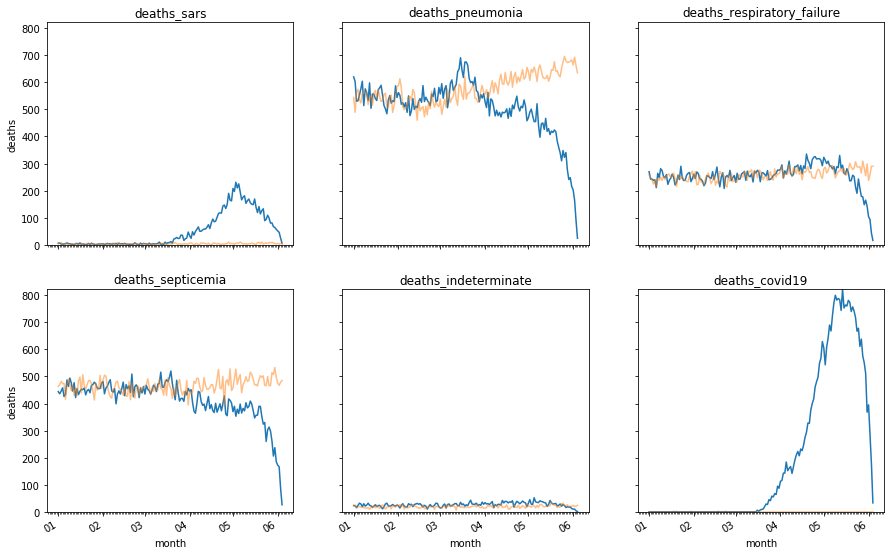

In [168]:
fig, axs = plt.subplots(2, 3,figsize=(15,10))
x = pd.Series(deaths_2020.index)

days = mdates.DayLocator()
months = mdates.MonthLocator()  # every month
months_fmt = mdates.DateFormatter('%m')

max_deaths = max(deaths_2020[death_cols].max().max(), deaths_2019[death_cols].max().max())

i = 0
j = 0

for col in death_cols:
    axs[i, j].plot(x, deaths_2020[col])
    axs[i, j].plot(x, deaths_2019[col], alpha = 0.5)
    axs[i, j].set_title(col);
    j += 1
    if j == 3:
        i = 1
        j = 0

# format the ticks
for i in range(2):
    for j in range(3):
        axs[i,j].xaxis.set_major_locator(months)
        axs[i,j].xaxis.set_major_formatter(months_fmt)
        axs[i,j].xaxis.set_minor_locator(days)
        axs[i,j].set_ylim(0,max_deaths)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()


for ax in axs.flat:
    ax.set(xlabel='month', ylabel='deaths')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

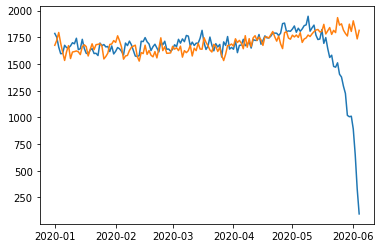

In [166]:
plt.plot(x,  deaths_2020['deaths_others']);
plt.plot(x,  deaths_2019['deaths_others']);

In [200]:
# Deaths by Age and Gender
deaths_gender_age = cr_states_det_2020.groupby(['gender', 'age_group']).sum().drop(columns = ['state_ibge_code'])

# reindex
deaths_gender_age = deaths_gender_age.reset_index()

# Define the sorter
sorter = ['9-', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89','90-99', '100+']

# Create the dictionary that defines the order for sorting
sorterIndex = dict(zip(sorter,range(len(sorter))))

# Generate a rank column that will be used to sort
# the dataframe numerically
deaths_gender_age['Rank'] = deaths_gender_age['age_group'].map(sorterIndex)

# Here is the result asked with the lexicographic sort
deaths_gender_age.sort_values(['gender', 'Rank'], ascending = [True, True], inplace = True)
deaths_gender_age.drop('Rank', 1, inplace = True)

deaths_gender_age.set_index(['gender', 'age_group'], inplace = True)

deaths_gender_age.style.background_gradient(cmap='Blues',subset=['deaths_sars'])\
                        .background_gradient(cmap='Reds',subset=['deaths_pneumonia'])\
                        .background_gradient(cmap='Greens',subset=['deaths_respiratory_failure'])\
                        .background_gradient(cmap='Purples',subset=['deaths_septicemia'])\
                        .background_gradient(cmap='Oranges',subset=['deaths_indeterminate'])\
                        .background_gradient(cmap='YlOrBr',subset=['deaths_others'])\
                        .background_gradient(cmap='PuRd',subset=['deaths_covid19'])\
                        .format("{:.0f}")

In [344]:
df_states = df_cases[df_cases['place_type'] == 'state']
cases_plot = df_states.merge(state_coor, on  = 'state')[['date', 'nome', 'state', 'confirmed', 'deaths', \
                                            'estimated_population_2019', 'confirmed_per_100k_inhabitants',\
                                             'death_rate', 'latitude', 'longitude']]

In [345]:
# filter last report date found in every state
idx = cases_plot.groupby(['state'])['date'].transform(max) == cases_plot['date']

# get values for this last report date
cases_plot = cases_plot[idx].reset_index(drop=True)

In [346]:
# Source: https://www.kaggle.com/tarunkr/covid-19-case-study-analysis-viz-comparisons

import folium
brazil_map = folium.Map(location=[-15.83, -47.86],tiles="cartodbpositron", zoom_start=4, max_zoom=6,min_zoom=2)

for i in range(0,len(cases_plot)):
    folium.Circle(
        location=[cases_plot.iloc[i]['latitude'], cases_plot.iloc[i]['longitude']],
        tooltip = "<h5 style='text-align:center;font-weight: bold'>"+cases_plot.iloc[i]['state']+"</h5>"+
                    "<div style='text-align:center;'>"+cases_plot.iloc[i]['nome']+"</div>"+
                    "<hr style='margin:10px;'>"+
                    "<ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
        "<li>Confirmed: "+str(cases_plot.iloc[i]['confirmed'])+"</li>"+
        "<li>Deaths:   "+str(cases_plot.iloc[i]['deaths'])+"</li>"+
        "<li>Mortality Rate:   "+str(cases_plot.iloc[i]['death_rate'])+"</li>"+
        "</ul>"
        ,
        radius=int(cases_plot.iloc[i]['confirmed']*2.5),
        color='blue',
        fill_color='blue',
        fill=True).add_to(brazil_map)
    
brazil_map

In [347]:
# Source: https://github.com/fititnt/gis-dataset-brasil

state_geo = 'https://raw.githubusercontent.com/fititnt/gis-dataset-brasil/master/uf/geojson/uf.json'
state_data = cases_plot[['state', 'confirmed']]
m = folium.Map(location=[-15.83, -47.86],tiles="cartodbpositron", zoom_start=4)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=state_data,
    columns=['state', 'confirmed'],
    key_on='feature.properties.UF_05',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Confirmed Cases'
).add_to(m)

folium.LayerControl().add_to(m)

m

In [348]:
state_data = cases_plot[['state', 'deaths']]
m = folium.Map(location=[-15.83, -47.86],tiles="cartodbpositron", zoom_start=4)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=state_data,
    columns=['state', 'deaths'],
    key_on='feature.properties.UF_05',
    fill_color='Reds',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Deaths'
).add_to(m)

folium.LayerControl().add_to(m)

m

In [364]:
df_data = df_states.groupby(['date', 'state'])[['confirmed', 'deaths']].max().reset_index().fillna(0)
df_data = df_data.merge(state_coor, on  = 'state')

In [ ]:
s = s.asfreq('m')

In [371]:
for name, group in df_data.groupby('state'):
    print (name, group['date'])

AC 1529    2020-03-17
1530    2020-03-18
1531    2020-03-19
1532    2020-03-20
1533    2020-03-21
           ...    
1603    2020-05-30
1604    2020-05-31
1605    2020-06-01
1606    2020-06-02
1607    2020-06-03
Name: date, Length: 79, dtype: object
AL 455    2020-03-08
456    2020-03-09
457    2020-03-10
458    2020-03-12
459    2020-03-13
          ...    
537    2020-06-01
538    2020-06-02
539    2020-06-03
540    2020-06-04
541    2020-06-05
Name: date, Length: 87, dtype: object
AM 1213    2020-03-13
1214    2020-03-18
1215    2020-03-19
1216    2020-03-20
1217    2020-03-21
           ...    
1288    2020-05-31
1289    2020-06-01
1290    2020-06-02
1291    2020-06-03
1292    2020-06-04
Name: date, Length: 80, dtype: object
AP 1838    2020-03-20
1839    2020-03-21
1840    2020-03-22
1841    2020-03-23
1842    2020-03-24
           ...    
1908    2020-05-30
1909    2020-05-31
1910    2020-06-01
1911    2020-06-02
1912    2020-06-04
Name: date, Length: 75, dtype: object
BA 276    2

In [367]:
fig = px.scatter_geo(df_data, lat = 'latitude', lon = 'longitude',
                     color=np.power(df_data['confirmed'],0.3)-2 , size= np.power(df_data['confirmed']+1,0.3)-1, 
                     hover_name='state',
                     hover_data=['confirmed'],
                     range_color= [0, max(np.power(df_data['confirmed'],0.3))], 
                     projection='natural earth', animation_frame='date', 
                     color_continuous_scale=px.colors.sequential.Plasma,
                     scope = 'south america',
                     title='COVID-19: Progression of spread'
                    )
fig.update_coloraxes(colorscale="hot")
fig.update(layout_coloraxis_showscale=False)
fig.show()

Data Cleaning